In [1]:
# from tensorflow.python.client import device_lib
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

[u'/cpu:0', u'/gpu:0']


In [2]:
import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

## Load data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_test_orig = X_test

## Data Prep

In [6]:
from keras import backend as K

In [7]:
img_rows, img_cols = 28, 28
if K.image_data_format() == "channels_first":
    shape_ord = (1, img_rows, img_cols)
else:    # channels last
    shape_ord = (img_rows, img_cols, 1)

### Preprocess and normalize data

In [8]:
X_train = X_train.reshape((X_train.shape[0], ) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [9]:
np.random.seed(1338)

X_test = X_test.copy()
Y = y_test.copy()

Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()

# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]


In [10]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape((X_six.shape[0] + X_not_six.shape[0],) + shape_ord)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [11]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)

((11918, 28, 28, 1), (11918,), (10000, 28, 28, 1), (10000,))


In [12]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

## Simple CNN

In [50]:
# -- Initializing the values for the convolution neural network

nb_epoch = 20  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

### step 1: define model

In [51]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

### step 2: compile model

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### step 3: fit

In [53]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/20
11918/11918 [==============================] - 1s - loss: 0.0942 - acc: 0.9654 - val_loss: 0.0359 - val_acc: 0.9857

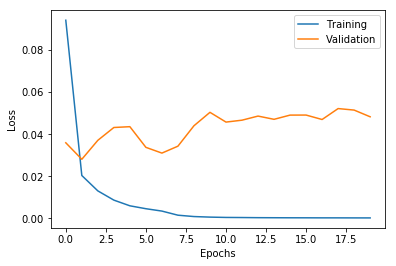

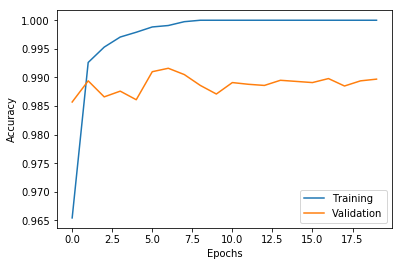

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### step 4: evaluate

In [55]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [56]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

('Test Loss:', 0.048272957133973025)
('Test Accuracy:', 0.98970000000000002)


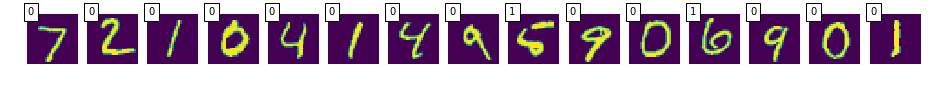

In [57]:

slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

### adding more dense layers

In [59]:

model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [60]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/20
11918/11918 [==============================] - 1s - loss: 0.2121 - acc: 0.9382 - val_loss: 0.1000 - val_acc: 0.9679

In [61]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

('Test score:', 0.047594164380617442)
('Test accuracy:', 0.98270000000000002)


### adding dropout

In [62]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/20
11918/11918 [==============================] - 1s - loss: 0.2528 - acc: 0.9308 - val_loss: 0.0900 - val_acc: 0.9725

In [64]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

('Test score:', 0.03121744535700418)
('Test accuracy:', 0.98839999999999995)


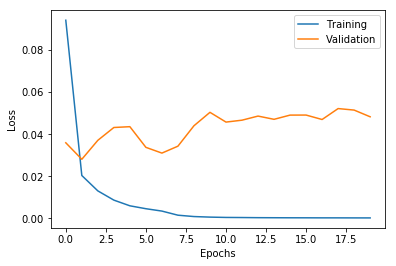

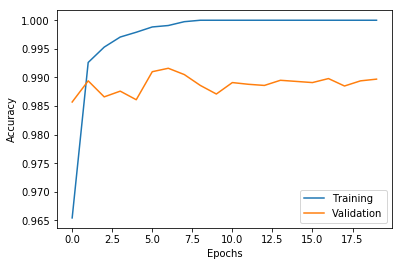

In [65]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### Adding more Convolutional Layers

In [66]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/20
11918/11918 [==============================] - 2s - loss: 0.3934 - acc: 0.8637 - val_loss: 0.1125 - val_acc: 0.9699

In [68]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

('Test score:', 0.036486051170621064)
('Test accuracy:', 0.98650000000000004)


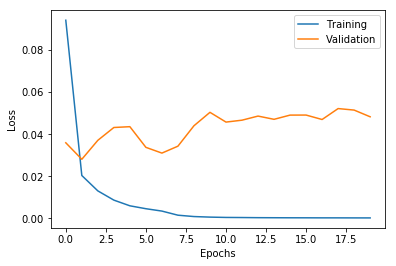

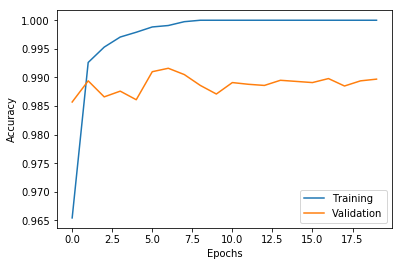

In [69]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

In [13]:

# Function for constructing the convolution neural network
# Feel free to add parameters, if you want

def build_model():
    """"""
    # -- Initializing the values for the convolution neural network

    nb_epoch = 30  # kept very low! Please increase if you have GPU

    batch_size = 64
    # number of convolutional filters to use
    nb_filters = 32
    # size of pooling area for max pooling
    nb_pool = 2
    # convolution kernel size
    nb_conv = 3

    # Vanilla SGD
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.50))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.50))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
        
    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_train, Y_train, verbose=0)
    print('Train Score:', score)
    print('Train Accuracy:', accuracy)
    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)
    
    

In [ ]:
build_model()

Train on 11918 samples, validate on 10000 samples
Epoch 1/30
11918/11918 [==============================] - 3s - loss: 0.4200 - acc: 0.8163 - val_loss: 0.1534 - val_acc: 0.9482